# Check Spatial Source Data to Ingested Rasdaman WCS Result

Run a (subset of the) FAIRiCUBE ingested data validation protocol on Rasdaman data cubes.

**This is a scratch notebook to experiment with relevant code fragments!** Eventually all code is to be included into a Python script that can be run from the commandline and perform the validation of multiple data cubes in batch.

# TODO

- Discuss Y bounds adjustments in WCS results with Dimitar/Bang
- Error handling in WCS related functions
- Add functions to extract data from source (tiff/cog?)
- Write code for the validation checks (match the EOX example)
- Write method to run all checks and output csv + log
- Change code to Python script and add main method
- Test run(s) with a few samples
- Automate for batch runs (csv input file?)
- Q: Validation of ingested data without source tiff available?
- Q: Validation steps not covered by this script?

In [2]:
import os
import xmltodict
import requests
import json

import numpy as np
import pandas as pd
import geopandas as gpd

from dotenv import load_dotenv
from pathlib import Path
from loguru import logger

from rasterio.io import MemoryFile

# environment settings path
env_path = Path('.') / 'env_secrets.txt'

In [6]:
def load_config(env_path: Path, log: logger) -> None:
    """
    Load dotenv file and retrieve environment variables for use.
    """
    # declare some variables for global use
    global rasdaman_username, rasdaman_password, rasdaman_endpoint, base_wcs_url
    # load environment variables from file
    load_dotenv(dotenv_path=env_path)
    # get rasdaman access info
    rasdaman_username = os.getenv("RASDAMAN_CRED_USERNAME")
    rasdaman_password = os.getenv("RASDAMAN_CRED_PASSWORD")
    rasdaman_endpoint = os.getenv("RASDAMAN_SERVICE_ENDPOINT")
    # create the base rasdaman WCS url
    base_wcs_url = rasdaman_endpoint + "?service=WCS&version=2.1.0"
    log.info(f"Using base WCS address: {base_wcs_url}")

In [7]:
load_config(env_path, logger)

2024-12-16 14:54:45.838 | INFO     | __main__:load_config:15 - Using base WCS address: http://fairicube.rasdaman.com:8080/rasdaman/ows?service=WCS&version=2.1.0


In [8]:
# define WCS access functions
# TODO add I/O error handling

def get_wcs_coverage_ids(log: logger = None) -> [str]:
    """
    Retrieve the list of available coverage (IDs) from the Rasdaman WCS service.
    
    Note: The Rasdaman host and auth variables need to be set!
    """
    response = requests.get(
        base_wcs_url + "&request=GetCapabilities", 
        auth=(rasdaman_username, rasdaman_password))
    wcs_capabilities = xmltodict.parse(response.content)
    wcs_coverage_summary = wcs_capabilities['wcs20:Capabilities']['wcs20:Contents']['wcs20:CoverageSummary']
    coverage_ids = [summary['wcs20:CoverageId'] for summary in wcs_coverage_summary]
    return coverage_ids


def get_wcs_coverage_description(coverage_id: str, log: logger = None) -> dict:
    """
    Retrieve a coverage description from the Rasdaman WCS service.
    
    Note: The Rasdaman host and auth variables need to be set!
    """
    response = requests.get(
        base_wcs_url + "&request=DescribeCoverage&coverageId=" + coverage_id,
        auth=(rasdaman_username, rasdaman_password))
    wcs_coverage_description = xmltodict.parse(response.content)    
    return wcs_coverage_description['wcs:CoverageDescriptions']['wcs:CoverageDescription']


def get_wcs_coverage_data(
    coverage_id: str, 
    year: int, 
    xs: tuple[int, int], 
    ys: tuple[int, int], 
    format: str = 'image/tiff',
    log: logger = None) -> None:
    """
    Retrieve coverage data from the Rasdaman WCS service.
    
    Note: The Rasdaman host and auth variables need to be set!
    """    
    cov_id = f"&COVERAGEID={coverage_id}"
    encode_format = f"&format={format}"
    subset = f'&subset=time("{year}-01-01") &subset=X({xs[0]}, {xs[1]}) &subset=Y({ys[0]}, {ys[1]})'

    request_url = base_wcs_url + "&request=GetCoverage" + cov_id + encode_format + subset
    if not log is None:
        log.debug(f"sending request: {request_url}")

    response = requests.get(
        request_url,
        auth=(rasdaman_username, rasdaman_password),
        verify=False)

    content = response.content

    # show content if there was an error
    if not response.ok:
        if not log is None:
            log.error(f"WCS error: {content}")

    return content

In [9]:
# test
get_wcs_coverage_ids()[0:5]

['AD4GD_GBIF',
 'ADC_Arable_Land_Markers_Autumn',
 'ADC_Arable_Land_Markers_Spring',
 'ADC_Crop_Parcels_Crop_Code',
 'ADC_Crop_Parcels_Field_ID']

In [10]:
# test
coverage_id = "ADC_Arable_Land_Markers_Autumn"
descr = get_wcs_coverage_description(coverage_id)

# show some relevant info
print(json.dumps(descr['@gml:id'], indent=2))
print(json.dumps(descr['gml:boundedBy'], indent=2))
#print(json.dumps(info, indent=2))

"ADC_Arable_Land_Markers_Autumn"
{
  "gml:Envelope": {
    "@srsName": "https://www.opengis.net/def/crs-compound?1=https://www.opengis.net/def/crs/OGC/0/AnsiDate?axis-label=\"time\"&2=https://www.opengis.net/def/crs/EPSG/0/28992",
    "@axisLabels": "time X Y",
    "@uomLabels": "d metre metre",
    "@srsDimension": "3",
    "gml:lowerCorner": "\"2018-01-01T00:00:00.000Z\" 136000 428495",
    "gml:upperCorner": "\"2022-12-31T23:59:59.999Z\" 223870 535555"
  }
}


In [11]:
# test
# TODO: use coordinates of study region(s)
data = get_wcs_coverage_data(
    coverage_id='ADC_Arable_Land_Markers_Autumn',
    year=2021,
    xs=(200000, 220000), # 10m step size
    ys=(470000, 490000), # 10m step size - TODO: why are NOT the proper dimensions returned?
    format='image/tiff', # application/netcdf for xarray data, but need tiff to retain CRS info
    log=logger)

2024-12-16 14:55:21.694 | DEBUG    | __main__:get_wcs_coverage_data:50 - sending request: http://fairicube.rasdaman.com:8080/rasdaman/ows?service=WCS&version=2.1.0&request=GetCoverage&COVERAGEID=ADC_Arable_Land_Markers_Autumn&format=image/tiff&subset=time("2021-01-01") &subset=X(200000, 220000) &subset=Y(470000, 490000)


In [12]:
# test
with MemoryFile(data) as memfile:
    with memfile.open() as ds:
        logger.info(f"name: {ds.name}")
        logger.info(f"bands: {ds.count}")
        logger.info(f"width: {ds.width}")
        logger.info(f"height: {ds.height}")
        logger.info(f"bounds: {ds.bounds}")
        for i in range(ds.count):
            bd = ds.read(i+1) #ndarray
            logger.info(f"band {i+1} shape: {bd.shape}")
            logger.info(f"band {i+1} min: {np.min(bd)}")
            logger.info(f"band {i+1} max: {np.max(bd)}")
            logger.info(f"band {i+1} mean: {np.mean(bd):.2f}")

2024-12-16 14:55:30.779 | INFO     | __main__:<module>:4 - name: /vsimem/9fe66665-f119-4f63-9f70-48b613a2bd0d/9fe66665-f119-4f63-9f70-48b613a2bd0d.tif
2024-12-16 14:55:30.780 | INFO     | __main__:<module>:5 - bands: 1
2024-12-16 14:55:30.780 | INFO     | __main__:<module>:6 - width: 2000
2024-12-16 14:55:30.781 | INFO     | __main__:<module>:7 - height: 2001
2024-12-16 14:55:30.781 | INFO     | __main__:<module>:8 - bounds: BoundingBox(left=200000.0, bottom=469995.0, right=220000.0, top=490005.0)
2024-12-16 14:55:30.787 | INFO     | __main__:<module>:11 - band 1 shape: (2001, 2000)
2024-12-16 14:55:30.787 | INFO     | __main__:<module>:12 - band 1 min: 0
2024-12-16 14:55:30.788 | INFO     | __main__:<module>:13 - band 1 max: 3
2024-12-16 14:55:30.790 | INFO     | __main__:<module>:14 - band 1 mean: 0.30


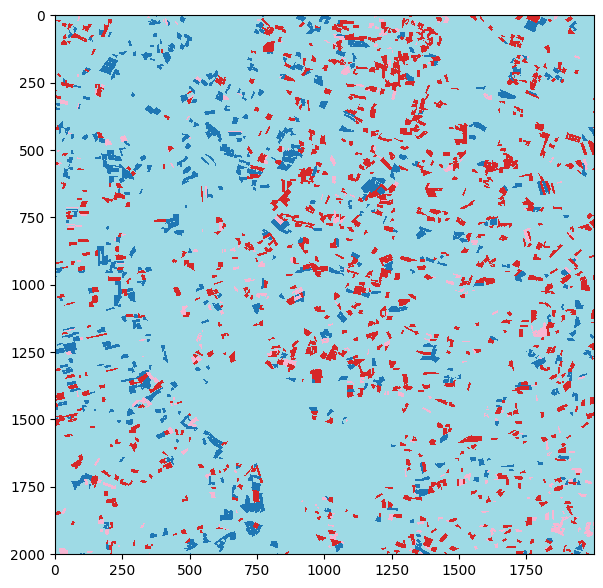

In [14]:
# test - plot data for visual inspection
import matplotlib.pyplot as plt
from rasterio import plot
from rasterio.plot import show_hist

# TODO assign proper colours

# plot the data of the first band
with MemoryFile(data) as memfile:
    with memfile.open() as ds:
        bd = ds.read(1)
        fig, ax = plt.subplots(1, figsize=(7, 7))
        plot.show(bd, cmap='tab20_r', interpolation='none', ax=ax)